In [24]:
import keras
from keras.datasets import mnist
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Flatten
from keras import optimizers
from keras.models import Sequential
from keras.layers import Input, Lambda, Dense, Flatten, Dropout, UpSampling2D, LeakyReLU, MaxPooling2D, BatchNormalization
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow import optimizers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt


In [2]:
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Rescale pixel values to [0, 1]
    rotation_range=20,         # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,     # Randomly shift images horizontally by up to 20% of width
    height_shift_range=0.2,    # Randomly shift images vertically by up to 20% of height
    shear_range=0.2,           # Apply random shear transformations
    zoom_range=0.2,            # Randomly zoom into images by up to 20%
    horizontal_flip=True,      # Randomly flip images horizontally
    fill_mode='nearest'        # Fill in missing pixels with nearest pixel values
)

# Define ImageDataGenerator for validation data (no augmentation)
validation_datagen = ImageDataGenerator(rescale=1./255)


In [3]:
# Set batch size
batch_size = 32

# Flow training images in batches using train_datagen
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/dataset 2000 image/archive (9) - Copy - Copy/Data/train',                 # Directory containing training images
    target_size=(224, 224),    # Resize images to match input size of VGG16
    batch_size=batch_size,     # Batch size
    class_mode='categorical'   # Specify categorical labels
)

# Flow validation images in batches using validation_datagen
validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/dataset 2000 image/archive (9) - Copy - Copy/Data/test',            # Directory containing validation images
    target_size=(224, 224),    # Resize images to match input size of VGG16
    batch_size=batch_size,     # Batch size
    class_mode='categorical'   # Specify categorical labels
)

Found 1447 images belonging to 3 classes.
Found 404 images belonging to 3 classes.


In [23]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Define the model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),  # Add dropout for regularization
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')
])

In [25]:
model.compile(loss='categorical_crossentropy',
                    optimizer=optimizers.Adam(),
                    metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_9 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_26 (Dropout)        (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dense_11 (Dense)            (None, 3)                 387       
                                                                 
Total params: 21170755 (80.76 MB)
Trainable params: 6456

In [27]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
# Define callbacks
checkpoint = ModelCheckpoint("model_checkpoint.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min', min_lr=1e-6)

callbacks = [checkpoint, lr_scheduler]

# Define learning rate scheduler
def lr_schedule(epoch):
    """
    Learning rate scheduler.
    """
    initial_lr = 0.01
    if epoch < 8:
        return initial_lr
    else:
        return initial_lr * 0.1

# Training configuration
epochs = 15
initial_learning_rate = 0.01
steps_per_epoch = len(train_generator)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Start training
start_time = datetime.now()

history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=validation_generator,
                    callbacks=callbacks)

# Calculate training duration
training_duration = datetime.now() - start_time
print("Training duration:", training_duration)


Epoch 1/15
46/46 [==============================] - ETA: 0s - loss: 1.2044 - accuracy: 0.5695
Epoch 1: val_loss improved from inf to 0.51836, saving model to model_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 634s 14s/step - loss: 1.2044 - accuracy: 0.5695 - val_loss: 0.5184 - val_accuracy: 0.7525 - lr: 0.0010
Epoch 2/15
46/46 [==============================] - ETA: 0s - loss: 0.5489 - accuracy: 0.7761
Epoch 2: val_loss improved from 0.51836 to 0.23918, saving model to model_checkpoint.h5
46/46 [==============================] - 58s 1s/step - loss: 0.5489 - accuracy: 0.7761 - val_loss: 0.2392 - val_accuracy: 0.9307 - lr: 0.0010
Epoch 3/15
46/46 [==============================] - ETA: 0s - loss: 0.4251 - accuracy: 0.8383
Epoch 3: val_loss did not improve from 0.23918
46/46 [==============================] - 56s 1s/step - loss: 0.4251 - accuracy: 0.8383 - val_loss: 0.2817 - val_accuracy: 0.8960 - lr: 0.0010
Epoch 4/15
46/46 [==============================] - ETA: 0s - loss: 0.4045 - accuracy: 0.8404
Epoch 4: val_loss improved from 0.23918 to 0.18829, saving model to model_checkpoint.h5
46/46 [==============================] - 57s 1s/step - loss: 0.4045

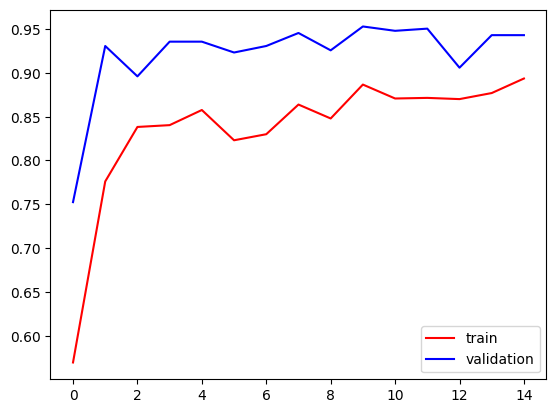

In [28]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

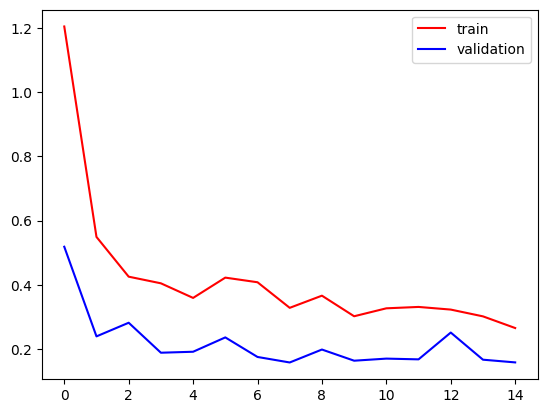

In [29]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [31]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

13/13 [==============================] - 11s 810ms/step - loss: 0.1581 - accuracy: 0.9431
Test Loss: 0.1581162065267563
Test Accuracy: 0.9430692791938782


In [33]:
from sklearn.metrics import classification_report

# Assuming you have already trained your model and loaded test data

# Evaluate the model on the training set
train_loss, train_accuracy = model.evaluate(train_generator)

# Predict classes for training set
train_predictions = model.predict(train_generator)
train_predicted_classes = np.argmax(train_predictions, axis=1)

# Get true labels for training set
train_true_classes = train_generator.classes

# Get class labels
class_labels = list(train_generator.class_indices.keys())

# Generate classification report for training set
train_report = classification_report(train_true_classes, train_predicted_classes, target_names=class_labels)

print("Training Classification Report:")
print(train_report)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)

# Predict classes for validation set
val_predictions = model.predict(validation_generator)
val_predicted_classes = np.argmax(val_predictions, axis=1)

# Get true labels for validation set
val_true_classes = validation_generator.classes

# Generate classification report for validation set
val_report = classification_report(val_true_classes, val_predicted_classes, target_names=class_labels)

print("Validation Classification Report:")
print(val_report)


46/46 [==============================] - 48s 1s/step
Training Classification Report:
              precision    recall  f1-score   support

     COVID19       0.33      0.32      0.32       460
      NORMAL       0.34      0.35      0.34       504
   PNEUMONIA       0.33      0.33      0.33       483

    accuracy                           0.33      1447
   macro avg       0.33      0.33      0.33      1447
weighted avg       0.33      0.33      0.33      1447

13/13 [==============================] - 10s 722ms/step
Validation Classification Report:
              precision    recall  f1-score   support

     COVID19       0.30      0.29      0.30       116
      NORMAL       0.36      0.41      0.39       160
   PNEUMONIA       0.35      0.30      0.33       128

    accuracy                           0.34       404
   macro avg       0.34      0.34      0.34       404
weighted avg       0.34      0.34      0.34       404

